In [28]:
import cirq
import numpy as np
import scipy
import sympy 
import matplotlib.pyplot as plt
import cirq.experiments.n_qubit_tomography as cen

import itertools
from functools import reduce
from tqdm import tqdm

from math import log

import random



In [3]:
def expZZ(t):
    ''' return the gate exp( -it * ZZ ) '''
       
    return cirq.ZZPowGate(exponent=2*t/np.pi, global_shift=-0.5)
   
def expX(t):
    ''' return the gate exp( -it * X ) '''
    return cirq.XPowGate(exponent=2*t/np.pi, global_shift=-0.5)

def is_Hermitian(M, rtol = 1e-5, atol = 1e-9):
    return np.allclose(M, np.conjugate(M.T), rtol=rtol, atol=atol)

def is_positive(M, tol = 1e-7):
    s = np.linalg.eigvalsh(M)
    assert (s[0] > -tol)
    for i in range(len(s)):
      if s[i] <= 0:
         s[i] = 1e-12
    return s

In [526]:
# define basic Pauli matrices
s_alpha = [np.array([[1,0],[0,1]],dtype=complex),np.array([[0,1],[1,0]],dtype=complex),np.array([[0,-1j],[1j,0]],dtype=complex),np.array([[1,0],[0,-1]],dtype=complex)]


# define the many-body spin operators
def sp(alpha,n,N):
    Sa = s_alpha[alpha]
    for i in range(n):
        Sa = np.kron(s_alpha[0],Sa)
    for j in range(n+1,N):
        Sa = np.kron(Sa,s_alpha[0])
    return Sa



def magn_exact_diagonalization(L,g,t,Npoints):
  # array containing the magnetization of individual basis states
  magnetization_basis_states = -np.array( [np.sum(2*np.array(cirq.big_endian_int_to_bits(val = n, bit_count = L)) - 1.0)/L for n in range(2**L)] )

  # create the hamiltonian
  hamiltonian = np.zeros((2**L,2**L),dtype=complex)
  for i in range(L):
      hamiltonian += g/2*sp(1,i,L)
      if i != L-1:
          hamiltonian += -1/2*sp(3,i,L)@sp(3,i+1,L)
  
  # diagonalize
  E,V = np.linalg.eig(hamiltonian)

  # time evolve
  magnetization = np.zeros(Npoints)
  initial_state = np.array([int(n==0) for n in range(2**L)])
  overlap = V.transpose().conj() @ initial_state
  for ind,T in enumerate(np.linspace(0,t,Npoints)):
    state_evolved = V @ (np.exp(-1j*T*E) * overlap)
    magnetization[ind] = np.sum(magnetization_basis_states * np.abs(state_evolved)**2)
  
  return magnetization

In [527]:
# System size
L = 10


# System initialization
chain = cirq.GridQubit.rect(1,L)


# Create a circuit
circuit_dummy = cirq.Circuit()
circuit_dummy.append(cirq.I(q) for q in chain)


# Simulate the wave function ...
result_exact = cirq.Simulator().simulate(circuit_dummy)

# ... and extract relevant objects
state = result_exact.state_vector()
state = state/np.linalg.norm(state) # in case not normalized for large system
print(state)
rho = result_exact.density_matrix_of(chain[ round(L/2):L ])

# compute an observable that consists of a sum of Pauli matrices
Paulix = cirq.PauliSum.from_pauli_strings([cirq.X(q) for q in chain])
q_map = result_exact.qubit_map
x_magntization = Paulix.expectation_from_state_vector(state, q_map).real/L

print(x_magntization)

# Perform repeated measurements ...
# repetition = 100
# circuit_measurement = cirq.Circuit()
# circuit_measurement.append(circuit_dummy)
# circuit_measurement.append( [cirq.measure(q) for q in chain], strategy = cirq.InsertStrategy.NEW_THEN_INLINE)  
# result_measure = cirq.Simulator().run(circuit_measurement, repetitions = repetition)
# # ... and extract relevant observables
# keys = [f'(0, {i})' for i in range(L)]
# counts = result_measure.multi_measurement_histogram(keys = keys)
# key0 = tuple( [0] * L )
# probability_0 = counts[key0]/repetition # probability_0 = 1 for circuit_dummy



# Tomography experiments
tomo_qubits = chain[round(L/2):L]
tomo_repetition = 1000
exp = cen.StateTomographyExperiment(tomo_qubits)
sam = cirq.Simulator()
probs = cen.get_state_tomography_data(sam, tomo_qubits, circuit_dummy, exp.rot_circuit, exp.rot_sweep, repetitions=tomo_repetition)
tomo_density_matrix = exp.fit_density_matrix(probs)._density_matrix # extract the density matrix from the probabilities (Linear Inversion)



# Also useful: convert numbers into bitstrings and vice versa
bit_string0 = [0] * L
number = cirq.big_endian_bits_to_int(bit_string0)
bit_string1 = cirq.big_endian_int_to_bits(val = number, bit_count = L)
print( bit_string0 == bit_string1 ) # True

[1.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
0.0
True


# Exercise 6

In [4]:
def evolve_basic(circ,qubits,g,dt):
    """ one step time evolution of qubits in circ by dt 
    through first order approximation"""
   
    ta = -g*dt/2
    Ua = expX(ta)
    
    tb = -dt/2
    Ub = expZZ(tb)

    N = len(qubits)

    for i in range(0,N,2): # even sites
        circ.append(Ub(qubits[i],qubits[i+1]))

    for i in range(1,N-1,2): # odd sites
        circ.append(Ub(qubits[i],qubits[i+1]))
    
    for qubit in qubits:
        circ.append(Ua(qubit)) # e^A = mult_i(exp(-gdt/2*Xi))



def evolve_symmetric(circ,qubits,g,dt):
    
    """ one step time evolution of qubits in circ by dt 
    through first order approximation"""
    
    ta = -g*dt/4
    Ua = expX(ta)
    
    tb = -dt/2
    Ub = expZZ(tb)
    
    N = len(qubits)

    for qubit in qubits:
        circ.append(Ua(qubit)) # e^A/2 = mult_i(exp(-gdt/4*Xi))

    for i in range(0,N,2): # even sites
        circ.append(Ub(qubits[i],qubits[i+1]))

    for i in range(1,N-1,2): # odd sites
        circ.append(Ub(qubits[i],qubits[i+1]))
    
    for qubit in qubits:
        circ.append(Ua(qubit)) # e^A/2 = mult_i(exp(-gdt/4*Xi))


# Exercise 7

In [5]:
def compute_magnetization(L, g, dt, t, approx='one', method='simulate', reps=1000):
    
    N = int(t/dt)

    simulator = cirq.Simulator()
    qubits = cirq.LineQubit.range(L)
    ops = [cirq.I(q) for q in qubits] 
    #mgntz = cirq.Circuit([ops, ops]) #initializing the circuit in all ups
    mgntz = cirq.Circuit(ops) #initializing the circuit in all ups

    mgntz_list = [] # magnetization list

    Z_all = cirq.PauliSum.from_pauli_strings([cirq.Z(q) for q in qubits]) # generating the sum_Z_i acting and all the qubits of the system as a pauli sum object

    for i in range(N+1):
        if method == 'run':
            expectations = []
            mgntz_measure = mgntz.copy()
            mgntz_measure.append(cirq.measure(*qubits, key='measure all'), strategy=cirq.InsertStrategy.NEW)
            result = simulator.run(mgntz_measure, repetitions = reps)
            counts = result.histogram(key='measure all')

            for i in range(L):
                N0 = 0
                N1 = 0  
                for integer, times  in counts.items():
                    if cirq.big_endian_int_to_bits(val = integer, bit_count = L)[i] == 0:
                        N0 += times
                    else:
                        N1 +=times
                # print(N0)
                # print(N1)
                expect = (N0-N1)/reps
                expectations.append(expect)
                print('expectation value for qubit:', i,'is' ,expect)
            mgntz_list.append( sum(expectations)/L)
           


        elif method == 'simulate':
            result = simulator.simulate(mgntz)
            state = result.final_state_vector

            state = state/np.linalg.norm(state) # in case not normalized for large system

            q_map = result.qubit_map
            z_magntization = Z_all.expectation_from_state_vector(state, q_map).real/L

            mgntz_list.append(z_magntization)

        print('iteration: ',i)
        if approx == 'one':
            evolve_basic(mgntz,qubits,g,dt) 
        elif approx == 'second':
            evolve_symmetric(mgntz,qubits,g,dt) 
        else:
            raise 'not a valid mode'

        #expectation = simulator.simulate_expectation_values(mgntz, observables= Z_all)[0].real/L
        #print('expectation: ',expectation)
    
        

    return mgntz_list



In [7]:
L = 10
g = 2

dt = 0.25
t = 5
N = int(t/dt)

mgntz_list_first = compute_magnetization(L, g, dt, t, approx='one')
mgntz_list_second = compute_magnetization(L, g, dt, t, approx='second')

ts_simulate = np.linspace(0, (len(mgntz_list_first)-2)*dt , len(mgntz_list_first))



iteration:  0
iteration:  1
iteration:  2
iteration:  3
iteration:  4
iteration:  5
iteration:  6
iteration:  7
iteration:  8
iteration:  9
iteration:  10
iteration:  11
iteration:  12
iteration:  13
iteration:  14
iteration:  15
iteration:  16
iteration:  17
iteration:  18
iteration:  19
iteration:  20
iteration:  0
iteration:  1
iteration:  2
iteration:  3
iteration:  4
iteration:  5
iteration:  6
iteration:  7
iteration:  8
iteration:  9
iteration:  10
iteration:  11
iteration:  12
iteration:  13
iteration:  14
iteration:  15
iteration:  16
iteration:  17
iteration:  18
iteration:  19
iteration:  20


In [531]:
ts = np.arange(0,t,dt)
magnetization = magn_exact_diagonalization(L,g,t=5,Npoints=N)

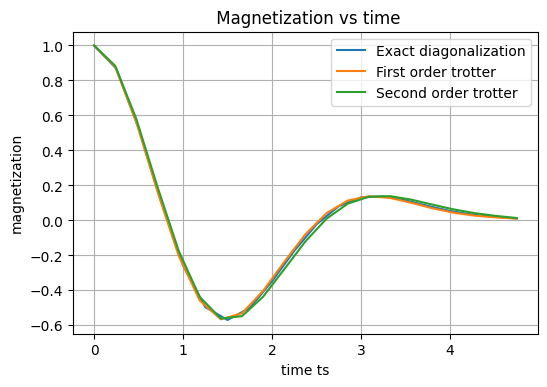

In [ ]:

plt.figure(dpi=(100))
plt.plot(ts, magnetization, label='Exact diagonalization')
plt.plot(ts_simulate, mgntz_list_first, label='First order trotter')
plt.plot(ts_simulate, mgntz_list_second, label='Second order trotter')
plt.title(' Magnetization vs time')
plt.xlabel('time ts')
plt.ylabel('magnetization')
plt.legend()
plt.grid()
plt.show()


## Comments:

for dt = 0.25 the results are already quite good.

for dt = 0.5 it looked still woozy

# Exercise 8

In [8]:
# exercise 8

simulator = cirq.Simulator()
qubits = cirq.LineQubit.range(L)
ops = [cirq.I(q) for q in qubits]
#mgntz = cirq.Circuit([ops, ops]) #initializing the circuit in all ups
mgntz = cirq.Circuit(ops)

result = simulator.simulate(mgntz)
state = result.final_state_vector

print(state.conj())

state = state/np.linalg.norm(state) # in case not normalized for large system

print(len(state))

[1.-0.j 0.-0.j 0.-0.j ... 0.-0.j 0.-0.j 0.-0.j]
1024


In [9]:
def compute_losch(L, g, dt, t, approx='one', method='simulate', reps=1000):
    
    N = int(t/dt)

    simulator = cirq.Simulator()
    qubits = cirq.LineQubit.range(L)
    ops = [cirq.I(q) for q in qubits]

    losch = cirq.Circuit(ops)

    gs_zero, gs_one = np.zeros(2**L), np.zeros(2**L)

    print(len(gs_zero))

    gs_zero[0] = 1
    gs_one[-1] = 1

    losch_zero = [] # projection onto the zero ground state
    losch_one = [] # projection onto the one ground state

    losch_total = [] #stores the values of lambda

    for i in range(N+1):

        if method == 'run':

            losch_measure = losch.copy()
            losch_measure.append(cirq.measure(*qubits, key='measure all'), strategy=cirq.InsertStrategy.NEW)
            result = simulator.run(losch_measure, repetitions = reps)
            counts = result.histogram(key='measure all')
            
            losch_total.append((counts[0] + counts[2**L - 1])/reps) #this should already be the values abs()**2
           

        elif method == 'simulate':
            result = simulator.simulate(losch)
            state = result.final_state_vector

            state = state/np.linalg.norm(state) # in case not normalized for large system

            print(len(state))

            projection0 = abs(np.inner(gs_zero.conj(), state))**2
            projection1 = abs(np.inner(gs_one.conj(), state))**2

            losch_zero.append(projection0)
            losch_one.append(projection1)

        print('iteration: ',i)
        if approx == 'one':
            evolve_basic(losch,qubits,g,dt) 
        elif approx == 'second':
            evolve_symmetric(losch,qubits,g,dt) 
        else:
            raise 'not a valid mode'

    if method == 'run':
        return losch_total
    elif method == 'simulate':
        losch_total = np.array(losch_zero) + np.array(losch_one)
        return losch_zero, losch_one, losch_total

In [ ]:
Ls = [6,8,10,12]

lambda0 =[]
lambda1 = []
lambdat = []

for L in Ls:
    print(L)
    losch_zero, losch_one, losch_total = compute_losch(L=L, g=2.0, dt=0.25, t=5)
    lambda0.append(losch_zero)
    lambda1.append(losch_one)
    lambdat.append(losch_total)

6
64
64
iteration:  0
64
iteration:  1
64
iteration:  2
64
iteration:  3
64
iteration:  4
64
iteration:  5
64
iteration:  6
64
iteration:  7
64
iteration:  8
64
iteration:  9
64
iteration:  10
64
iteration:  11
64
iteration:  12
64
iteration:  13
64
iteration:  14
64
iteration:  15
64
iteration:  16
64
iteration:  17
64
iteration:  18
64
iteration:  19
64
iteration:  20
8
256
256
iteration:  0
256
iteration:  1
256
iteration:  2
256
iteration:  3
256
iteration:  4
256
iteration:  5
256
iteration:  6
256
iteration:  7
256
iteration:  8
256
iteration:  9
256
iteration:  10
256
iteration:  11
256
iteration:  12
256
iteration:  13
256
iteration:  14
256
iteration:  15
256
iteration:  16
256
iteration:  17
256
iteration:  18
256
iteration:  19
256
iteration:  20
10
1024
1024
iteration:  0
1024
iteration:  1
1024
iteration:  2
1024
iteration:  3
1024
iteration:  4
1024
iteration:  5
1024
iteration:  6
1024
iteration:  7
1024
iteration:  8
1024
iteration:  9
1024
iteration:  10
1024
iteration

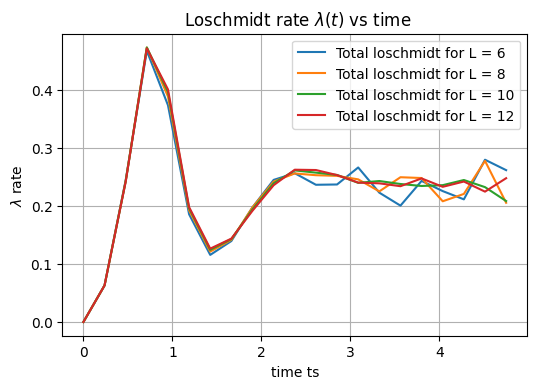

In [ ]:
plt.figure(dpi=(100))
for i, L in enumerate(Ls):
    plt.plot(ts_simulate, -np.log(lambdat[i])/L, label='Total loschmidt for L = {}'.format(L))
plt.title(' Loschmidt rate $\lambda(t)$ vs time')
plt.xlabel('time ts')
plt.ylabel('$\lambda$ rate')
plt.legend()
plt.grid()
plt.show()

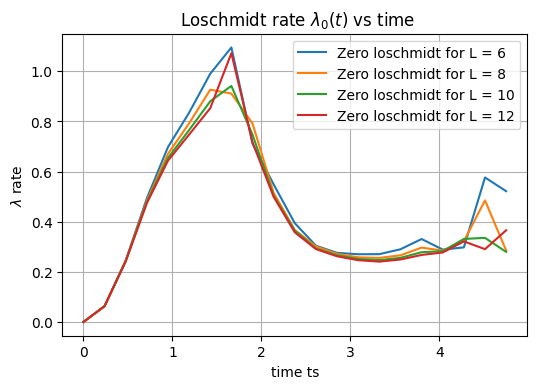

In [ ]:
plt.figure(dpi=(100))
for i, L in enumerate(Ls):
    plt.plot(ts_simulate, -np.log(lambda0[i])/L, label='Zero loschmidt for L = {}'.format(L))
plt.title(' Loschmidt rate $\lambda_0(t)$ vs time')
plt.xlabel('time ts')
plt.ylabel('$\lambda$ rate')
plt.legend()
plt.grid()
plt.show()

/var/folders/_n/xw2mchz92t9_fcbxg7lwsdwh0000gn/T/ipykernel_9140/1456176578.py:3: RuntimeWarning: divide by zero encountered in log
  plt.plot(ts_simulate, -np.log(lambda1[i])/L, label='One loschmidt for L={}'.format(L))


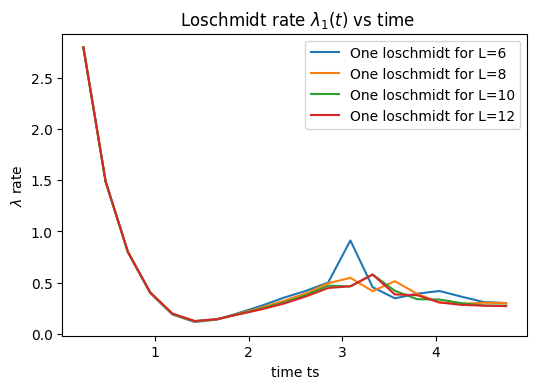

In [ ]:
plt.figure(dpi=(100))
for i, L in enumerate(Ls):
    plt.plot(ts_simulate, -np.log(lambda1[i])/L, label='One loschmidt for L={}'.format(L))
plt.title(' Loschmidt rate $\lambda_1(t)$ vs time')
plt.xlabel('time ts')
plt.ylabel('$\lambda$ rate')
plt.legend()
plt.show()

In [ ]:
gs = np.arange(0.5,1.6,0.1)


lambda0_gs =[]
lambda1_gs = []
lambdat_gs = []

for g in gs:
    print(g)
    losch_zero, losch_one, losch_total = compute_losch(L=12, g=g, dt=0.25, t=5)
    lambda0_gs.append(losch_zero)
    lambda1_gs.append(losch_one)
    lambdat_gs.append(losch_total)

0.5
4096
4096
iteration:  0
4096
iteration:  1
4096
iteration:  2
4096
iteration:  3
4096
iteration:  4
4096
iteration:  5
4096
iteration:  6
4096
iteration:  7
4096
iteration:  8
4096
iteration:  9
4096
iteration:  10
4096
iteration:  11
4096
iteration:  12
4096
iteration:  13
4096
iteration:  14
4096
iteration:  15
4096
iteration:  16
4096
iteration:  17
4096
iteration:  18
4096
iteration:  19
4096
iteration:  20
0.6
4096
4096
iteration:  0
4096
iteration:  1
4096
iteration:  2
4096
iteration:  3
4096
iteration:  4
4096
iteration:  5
4096
iteration:  6
4096
iteration:  7
4096
iteration:  8
4096
iteration:  9
4096
iteration:  10
4096
iteration:  11
4096
iteration:  12
4096
iteration:  13
4096
iteration:  14
4096
iteration:  15
4096
iteration:  16
4096
iteration:  17
4096
iteration:  18
4096
iteration:  19
4096
iteration:  20
0.7
4096
4096
iteration:  0
4096
iteration:  1
4096
iteration:  2
4096
iteration:  3
4096
iteration:  4
4096
iteration:  5
4096
iteration:  6
4096
iteration:  7
4

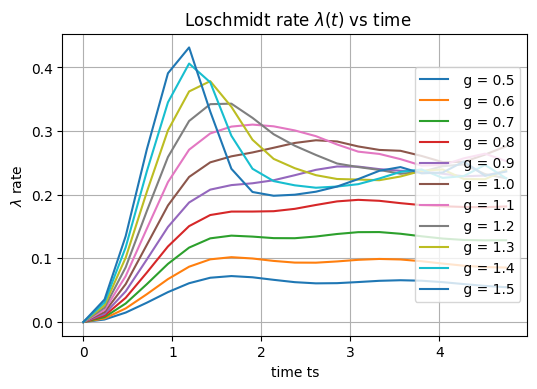

In [ ]:
L = 12

plt.figure(dpi=(100))
for i, g in enumerate(gs):
    plt.plot(ts_simulate, -np.log(lambdat_gs[i])/L, label=' g = {}'.format(round(g,3)))
plt.title(' Loschmidt rate $\lambda(t)$ vs time')
plt.xlabel('time ts')
plt.ylabel('$\lambda$ rate')
plt.legend(loc='right')
plt.grid(True)
plt.show()

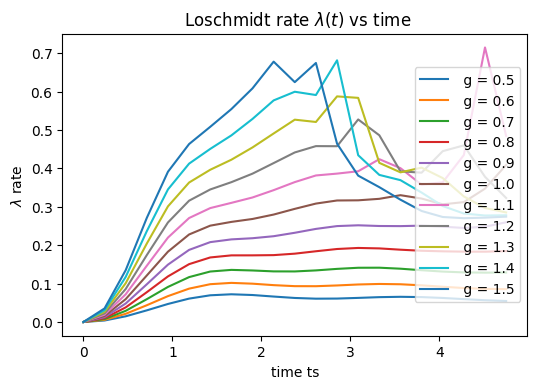

In [ ]:
L = 12

plt.figure(dpi=(100))
for i, g in enumerate(gs):
    plt.plot(ts_simulate, -np.log(lambda0_gs[i])/L, label=' g = {}'.format(round(g,3)))
plt.title(' Loschmidt rate $\lambda(t)$ vs time')
plt.xlabel('time ts')
plt.ylabel('$\lambda$ rate')
plt.legend(loc='right')
plt.show()

/var/folders/_n/xw2mchz92t9_fcbxg7lwsdwh0000gn/T/ipykernel_9140/3247963563.py:5: RuntimeWarning: divide by zero encountered in log
  plt.plot(ts_simulate, -np.log(lambda1_gs[i])/L, label=' g = {}'.format(round(g,3)))


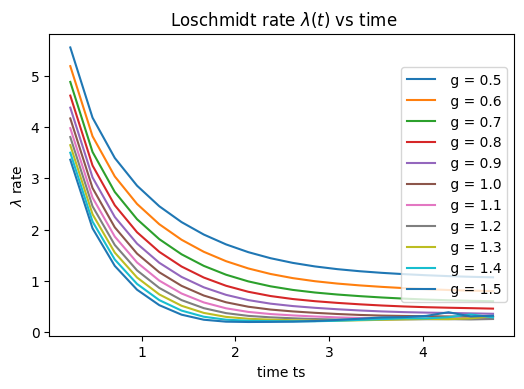

In [ ]:
L = 12

plt.figure(dpi=(100))
for i, g in enumerate(gs):
    plt.plot(ts_simulate, -np.log(lambda1_gs[i])/L, label=' g = {}'.format(round(g,3)))
plt.title(' Loschmidt rate $\lambda(t)$ vs time')
plt.xlabel('time ts')
plt.ylabel('$\lambda$ rate')
plt.legend(loc='right')
plt.show()

# Exercise 9

In [10]:
L = 4

simulator = cirq.Simulator(seed=2)
qubits = cirq.LineQubit.range(L)
ops = [cirq.I(q) for q in qubits]
#mgntz = cirq.Circuit([ops, ops]) #initializing the circuit in all ups
test = cirq.Circuit(ops)

reps = 100

#est.append([cirq.X(q) for q in qubits])
test.append([cirq.H(q) for q in qubits])
test.append(cirq.measure(*qubits[:2], key='measure all'), strategy=cirq.InsertStrategy.NEW)
print(test)
result1 = simulator.run(test, repetitions = reps)
counts = result1.histogram(key='measure all')
print(dict(sorted(counts.items())))



0: ───I───H───M('measure all')───
              │
1: ───I───H───M──────────────────

2: ───I───H──────────────────────

3: ───I───H──────────────────────
{0: 36, 1: 16, 2: 20, 3: 28}


In [595]:
srt = dict(sorted(counts.items()))
print(srt)
print(list(srt.keys()))
print(list(srt.values()))

bitstrings = [cirq.big_endian_int_to_bits(val = k, bit_count = L) for k in srt.keys()]
bitstrings[0]

{0: 18, 1: 9, 2: 9, 3: 9, 4: 18, 5: 7, 6: 11, 7: 19}
[0, 1, 2, 3, 4, 5, 6, 7]
[18, 9, 9, 9, 18, 7, 11, 19]


[0, 0, 0]

In [606]:
list(srt.items())[-1][1]

19

In [ ]:
#cirq.plot_state_histogram(samples, plt.subplot())
#plt.show()



expectations = []

for i in range(len(qubits)):
    N0 = 0
    N1 = 0  
    for number, times  in counts.items():
        #print(cirq.big_endian_int_to_bits(val = number, bit_count = L), times)
        if cirq.big_endian_int_to_bits(val = number, bit_count = L)[i] == 0:
            N0 += times
        else:
            N1 +=times

    print(N0)
    print(N1)
    expect = (N0-N1)/reps
    expectations.append(expect)
    print('expectation value for qubit:', i,'is' ,expect)

sum(expectations)/L

49
51
expectation value for qubit: 0 is -0.02
54
46
expectation value for qubit: 1 is 0.08


0.03

In [ ]:
L = 10
g = 2

dt = 0.25
t = 5

N = int(t/dt)

mgntz_list_9= compute_magnetization(L, g, dt, t, approx='one', method='run', reps=1000)

ts_simulate_9 = np.linspace(0, (len(mgntz_list_first)-2)*dt , len(mgntz_list_first))

expectation value for qubit: 0 is 1.0
expectation value for qubit: 1 is 1.0
expectation value for qubit: 2 is 1.0
expectation value for qubit: 3 is 1.0
expectation value for qubit: 4 is 1.0
expectation value for qubit: 5 is 1.0
expectation value for qubit: 6 is 1.0
expectation value for qubit: 7 is 1.0
expectation value for qubit: 8 is 1.0
expectation value for qubit: 9 is 1.0
iteration:  9
expectation value for qubit: 0 is 0.872
expectation value for qubit: 1 is 0.862
expectation value for qubit: 2 is 0.876
expectation value for qubit: 3 is 0.882
expectation value for qubit: 4 is 0.896
expectation value for qubit: 5 is 0.872
expectation value for qubit: 6 is 0.902
expectation value for qubit: 7 is 0.87
expectation value for qubit: 8 is 0.892
expectation value for qubit: 9 is 0.864
iteration:  9
expectation value for qubit: 0 is 0.536
expectation value for qubit: 1 is 0.54
expectation value for qubit: 2 is 0.514
expectation value for qubit: 3 is 0.568
expectation value for qubit: 4 is 

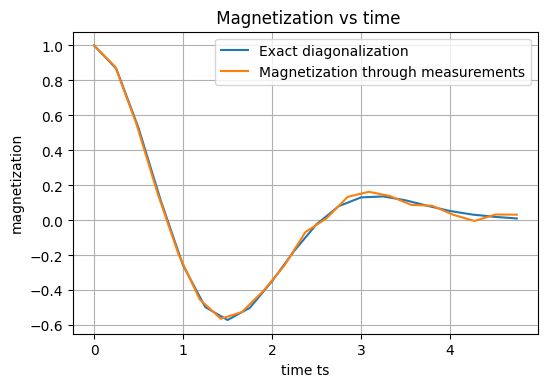

In [ ]:
plt.figure(dpi=(100))
plt.plot(ts, magnetization, label='Exact diagonalization')
plt.plot(ts_simulate_9, mgntz_list_9, label='Magnetization through measurements')
plt.title(' Magnetization vs time')
plt.xlabel('time ts')
plt.ylabel('magnetization')
plt.legend()
plt.grid()
plt.show()

# How many repetitions:
for 10 and 100 the results are not so accurate, the minimum should be on the order of $10^3$

In [ ]:
L = 10
g = 2

dt = 0.20
t = 5

N = int(t/dt)

losch_echo9 = compute_losch(L, g, dt, t, approx='one', method='run', reps=10000)
ts_losch_9 = np.linspace(0, (len(losch_echo9)-2)*dt , len(losch_echo9))

1024
iteration:  0
iteration:  1
iteration:  2
iteration:  3
iteration:  4
iteration:  5
iteration:  6
iteration:  7
iteration:  8
iteration:  9
iteration:  10
iteration:  11
iteration:  12
iteration:  13
iteration:  14
iteration:  15
iteration:  16
iteration:  17
iteration:  18
iteration:  19
iteration:  20
iteration:  21
iteration:  22
iteration:  23
iteration:  24
iteration:  25


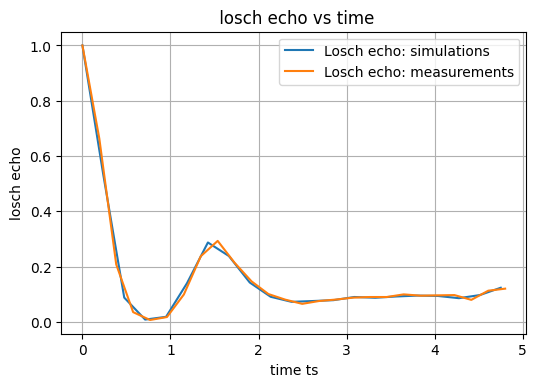

In [ ]:
plt.figure(dpi=(100))
plt.plot(ts_simulate_9, lambdat[2], label='Losch echo: simulations',)
plt.plot(ts_losch_9, losch_echo9,label='Losch echo: measurements',)
plt.title(' losch echo vs time')
plt.xlabel('time ts')
plt.ylabel('losch echo')
plt.legend()
plt.grid()
plt.show()

In [ ]:
from math import log, e

In [ ]:
test = []

for x in losch_echo9:
    test.append(-log(x)/L)

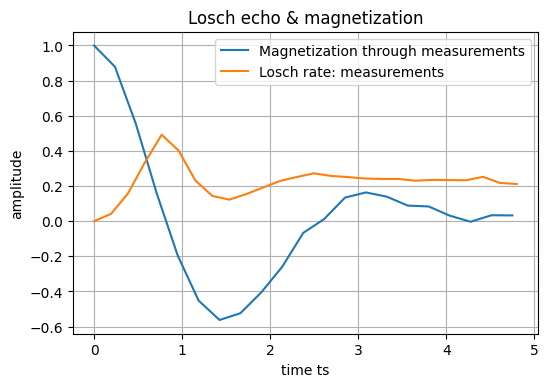

In [ ]:
plt.figure(dpi=(100))
plt.plot(ts_simulate_9, mgntz_list_9, label='Magnetization through measurements')
plt.plot(ts_losch_9, -np.log(losch_echo9)/L,label='Losch rate: measurements')
plt.title('Losch echo & magnetization')
plt.xlabel('time ts')
plt.ylabel('amplitude')
plt.legend()
plt.grid()
plt.show()

In [ ]:
bit_string0 = [0] * L
number = cirq.big_endian_bits_to_int(bit_string0)
bit_string1 = cirq.big_endian_int_to_bits(val = number, bit_count = L)
print( bit_string0 == bit_string1 ) # True

True


# Exercise 17 

In [11]:
def U2_CUE(qubit, symbs):

    """
    symbs: symbs[0] = a, symbs[1] = b, symbs[2] = c
    applie U = Rz(a+c)Ry(b)Rz(a-c) to qubit
    """
    a = symbs[0]
    b = symbs[1]
    c = symbs[2]

    Rz1 = cirq.unitary(cirq.rz(c-a))
    Ry = cirq.unitary(cirq.ry(-2*b))
    Rz2 = cirq.unitary(cirq.rz(-(a+c)))
   
    U = cirq.MatrixGate(Rz2@Ry@Rz1)

    return U(qubit)
    

In [12]:
class U2_CUE_2(cirq.Gate):
    def __init__(self,symbs):
        super(U2_CUE_2, self)
        self.a = symbs[0]
        self.b = symbs[1]
        self.c = symbs[2]

    def _num_qubits_(self):
        return 1

    def _unitary_(self):
        return np.array([
            [np.exp(1j*self.a)*np.cos(self.b), np.exp(1j*self.c)*np.sin(self.b)],
            [np.exp(-1j*self.c)*np.sin(self.b), np.exp(-1j*self.a)*np.cos(self.b)],
        ])

    def _circuit_diagram_info_(self, args):
        return f"U2({[np.exp(1j*self.a)*np.cos(self.b), np.exp(1j*self.c)*np.sin(self.b)]} \n {[np.exp(-1j*self.c)*np.sin(self.b), np.exp(-1j*self.a)*np.cos(self.b)]})"

In [13]:
name = 5
print(f"{name} \n emiliano")

5 
 emiliano


In [30]:
q_chain = cirq.LineQubit.range(2)
test = cirq.Circuit()

X = np.array([[0,1],[1,0]])

#Egate = cirq.MatrixGate(Rz@Ry)

symbs = [0,np.pi/4,0]
a = symbs[0]
b = symbs[1]
c = symbs[2]

#test.append([U2_CUE(qubit=q, symbs=symbs) for q in q_chain])

test.append([U2_CUE_2(symbs).on(q) for q in q_chain])

print(test)

result = simulator.simulate(test)
print('Bra-ket notation for the wavefunction:')
print(result.dirac_notation()) #this is correct

test.append(cirq.measure(qubits[0], key='0'), strategy=cirq.InsertStrategy.NEW)
reps = 100
result = simulator.run(test, repetitions = reps)
counts = result.histogram(key='0')
X = computeX(La=1, counts=counts, reps=reps)
X

0: ───U2([(0.7071067811865476+0j), (0.7071067811865475+0j)] ───
       [(0.7071067811865475+0j), (0.7071067811865476+0j)])

1: ───U2([(0.7071067811865476+0j), (0.7071067811865475+0j)] ───
       [(0.7071067811865475+0j), (0.7071067811865476+0j)])
Bra-ket notation for the wavefunction:
0.5|00⟩ + 0.5|01⟩ + 0.5|10⟩ + 0.5|11⟩


0.5216

In [22]:
def hamming(s1,s2):
    
    """ calculate the hamming distance between bitstring 1 and bitstring 2
    defined as the number of bits that these differed on.
    Assumption: s1 and s2 are datatype = list
    """
    s1 = np.array(s1)
    s2 = np.array(s2)
    
    return sum((s1 + s2)%2)

In [ ]:
s1 = [0,0,1,1]
s2 = [1,1,0,1]

hamming(s1,s2)

3

In [539]:
# chose a and c uniformly from 2pi
samples = 10
a,c = np.random.uniform(0,2*np.pi, size=(2,1))[:,0]
b = np.random.uniform(0,np.pi/2)


In [17]:
def computeX(La, counts, reps=2000):

    """
    input:

    - counts: object obtained from calling cirq.Simulator().run().histogram(). Contains both the keys and the counts for each key
    ->Note: dictionary will only contain the values of those bitstrings that have !=0 probability
    - La = length of the qubit system to be measured

    output:

    - X: to be used in the -log(X) formula to calculate the second Renyi Entropy
    """

    counts = dict(sorted(counts.items()))

    list_counts = list(counts.items()) # list of tuples. Each tuple contains the pair of (key,value)
    # bitstrings = [cirq.big_endian_int_to_bits(val = k, bit_count = La) for k in counts.keys()] # SA in the formula
    # probabilities = list(counts.values()) #Pu(SA) in the formula
    #print(list_counts)
    X = 0

    for s in itertools.product(list_counts, list_counts):
        #print(s)
        # s is a tuple containing (list_counts[i],list_counts[j]) for all possible combinations of i and j
        sa = cirq.big_endian_int_to_bits(val = s[0][0], bit_count = La)
        sa_prime = cirq.big_endian_int_to_bits(val = s[1][0], bit_count = La)
        D = hamming(sa,sa_prime)
        #print(D)
        pu_sa = s[0][1]/reps
        pu_sa_prime = s[1][1]/reps
        X += (-0.5)**D *pu_sa*pu_sa_prime

    return X*2**La

In [754]:
def Bell(n):
    q_chain = cirq.LineQubit.range(2)
    bell = cirq.Circuit()

    bell.append(cirq.H(q_chain[0]))
    bell.append(cirq.CNOT(q_chain[0],q_chain[1]))
    
    if n == 1:
        return bell, q_chain
    elif n==2:
        bell.append(cirq.Z(q_chain[1]))
        return bell, q_chain
    elif n==3:
        bell.append(cirq.X(q_chain[1]))
        return bell, q_chain
    elif n==4:
        bell.append(cirq.X(q_chain[1]))
        bell.append(cirq.Z(q_chain[0]))
        return bell, q_chain

bell, q_chain = Bell(1)
print(bell)

simulator = cirq.Simulator()
result = simulator.simulate(bell)
print('Bra-ket notation for the wavefunction:')
print(type(result.density_matrix_of()))

# bell.append(cirq.measure(q_chain[0], key='m'), strategy=cirq.InsertStrategy.NEW)
# reps = 2000
# result = simulator.run(bell, repetitions = reps)
# counts = result.histogram(key='m')
# print(counts)

# -log(computeX(La=1, counts=counts, reps=2000),2)

0: ───H───@───
          │
1: ───────X───
Bra-ket notation for the wavefunction:
<class 'numpy.ndarray'>


In [20]:
# functions for analytical calculations

def partial_trace(rho,dimA,dimB):
    
    rho_prime = rho.reshape(dimA,dimB,dimA,dimB)
    rhoA = np.trace(rho_prime, axis1=1, axis2=3)
    rhoB = np.trace(rho_prime, axis1=0, axis2=2)
    
    return (rhoA, rhoB)


def Simulate_RenyiEntropy(circ, La, L,simulator=cirq.Simulator()):

    result = simulator.simulate(circ)
    rho = result.density_matrix_of()
    Lb = L-La
    rhol,_ = partial_trace(rho,2**La,2**Lb)

    S = -log(np.trace(rhol@rhol),2)

    return S

In [ ]:
np.log

In [21]:
def renyi_entropy(L, La, dt=0.1, t=5, g=2, instances=200, method='run', reps=2000):
    
    assert La <= L, 'Subsystem should be at most the size of the total system'

    seed = random.seed(2)

    N = int(t/dt)
    simulator = cirq.Simulator(seed=seed)
    qubits = cirq.LineQubit.range(L)
    ops = [cirq.I(q) for q in qubits] # all identities
    circuit = cirq.Circuit(ops) # initializing the circuit in all ups

    rentropy = [] # renyi entropy list depending on time
    
    for j in tqdm(range(N+1)): #this will simulate the time
        if method == 'run':
            X = 0
            for i in range(instances): # we will have 200 instances
                # simulating the a,b,c for this instance
                a,c = np.random.uniform(0,2*np.pi, size=(2,L))
                b = np.random.uniform(0,np.pi/2, L)
                symbs = [a,b,c]
                circuit_measure = circuit.copy()
                
                for i,q in enumerate(qubits[:La]):
                    circuit_measure.append(U2_CUE(qubit=q, symbs=list(list(zip(*symbs))[i])))
                    #circuit_measure.append(U2_CUE_2(symbs=list(list(zip(*symbs))[i])).on(q))
                circuit_measure.append(cirq.measure(*qubits[:La], key='measure all'), strategy=cirq.InsertStrategy.NEW)
                result = simulator.run(circuit_measure, repetitions = reps)
                counts = result.histogram(key='measure all')

                X += computeX(La=La, counts=counts, reps=reps)
                    #print(X)
            
            S2 = -log(X/instances,2)
            rentropy.append(S2)

        elif method == 'simulate':
            rentropy.append(Simulate_RenyiEntropy(circuit, La, L))

        evolve_basic(circuit,qubits,g,dt) 

    return rentropy


In [756]:
testing = [1,2,3,4,5,6]
A =  3
testing[:A]

[1, 2, 3]

In [722]:
L = 2

a,c = np.random.uniform(0,2*np.pi, size=(2,L))
b = np.random.uniform(0,np.pi/2, L)

symbs = [a,b,c]

print(symbs)

for i in range(L):
    print(list(list(zip(*symbs))[i]))

[array([2.93474133, 1.91222717]), array([0.37422863, 1.34769218]), array([1.07595265, 1.46648217])]
[2.934741328632108, 0.3742286261840108, 1.0759526534476955]
[1.9122271663683614, 1.3476921793366983, 1.4664821670246004]


In [51]:
dt = 0.25
test2 = renyi_entropy(L=2, La=1, dt=0.25, t=5, instances=500, reps=2000)
ts_17 = np.linspace(0, (len(test2)-2)*dt , len(test2))

100%|██████████| 21/21 [01:20<00:00,  3.82s/it]


In [56]:
import warnings
warnings.filterwarnings('ignore')
dt = 0.25
test2_simulate = renyi_entropy(L=2, La=1, dt=0.25, t=5, method='simulate')
ts_17_simulate = np.linspace(0, (len(test2_simulate)-2)*dt , len(test2_simulate))

100%|██████████| 21/21 [00:00<00:00, 223.44it/s]


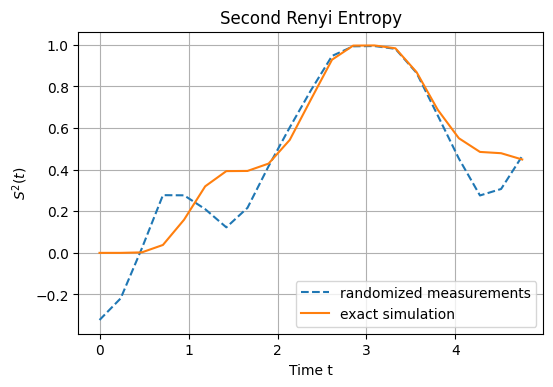

In [57]:
plt.figure(dpi=(100))
plt.plot(ts_17, test2, '--',label='randomized measurements')
plt.plot(ts_17_simulate,test2_simulate,label='exact simulation')
plt.title('Second Renyi Entropy')
plt.xlabel('Time t')
plt.ylabel('$S^2(t)$')
plt.legend()
plt.grid()
plt.show()

In [656]:
renyi_entropy = _

In [657]:
renyi_entropy

[0.09297992928342395,
 0.010522315210440919,
 0.06525324794061521,
 0.04432976645096518,
 0.0029520094006373425,
 -0.001748247726031774,
 0.02031921404715667,
 0.029126770039972338,
 0.0038117189270786365,
 0.027023172251110027,
 -0.0037800981419824514,
 -0.0006988525225957628,
 -0.01240991110607991,
 -0.1208376566165417,
 -0.04244414257887288,
 0.029882075836682023,
 0.07907545204927441,
 -0.005725859878239965,
 0.024545768683737642,
 -0.03419551535260378,
 -0.07394367952754943,
 -0.045791835006895674,
 0.014929527734532284,
 -0.10125375784039686,
 -0.11211638865065177,
 0.00990689092435924,
 -0.013180210816695683,
 -0.0022343344288516254,
 0.025386565796781307,
 -0.03908969598458025,
 0.03297244032864829,
 0.11967777796600185,
 -0.014798949896302463,
 0.09038672806174192,
 0.0392510060779979,
 0.010812683143701856,
 0.10398816977893345,
 0.06025589042350225,
 0.12107316997177316,
 0.15726171116368154,
 0.07972764855917107,
 0.05477902612430049,
 0.05895561731592398,
 0.15024447853673

In [661]:
np.savetxt('exercise17_test1.txt', renyi_entropy)